# LiDAR from pulses to point clouds

This tutorial introduces airborne LiDAR as a data source, and demonstrates some basic analysis. We will:
- explain LiDAR fundamentals
- examine some LiDAR waveform data
- examine some points derived from LiDAR
- interpolate points into a mesh or grid
- evalauate our results

It uses the following technical concepts:
- reading HDF files into dictionary-like objects
- reading text files into Pandas
- plotting subsets of HDF files using Matplotlib
- peak detection in Scipy
- array manipulation in Numpy

## LiDAR fundamentals

LiDAR is an acronym for light detection and ranging. In essence, LiDAR instruments are rangefinders - they emit focused light at a target, and estimate the range to the target using the time between emission and return (dT), and the speed of light (range = dT * speed of light).

Light is always emitted as a single 'pulse' of light with an energetic signature approximating a Gaussian distribution. Increasingly, LiDAR instruments capture the 'waveform' of the return - or a range of reflection intensities over a very short period of time - as the laser pulse reflection is observed. These 'waveforms' are analysed to determine likely targets, and then ranges to those targets.

The diagram below shows what a sample returned waveform might look like over a relatively open canopy.

![waveform concepts](./data/waveforms.png)

This is essentially a histogram of returned energy. Where there are peaks, there's a lot of energy coming back to the sensor, so we've hit a surface that has reflected some light! A LiDAR **point cloud** is a georeferenced set of these peaks.

In this workshop we'll investigate some LiDAR return waveforms, identify peaks, and try some methods of turning these data into meaningful information. We don't cover how LiDAR is georeferenced - that's a story for another time.

### Set up our toolbox

In [1]:
# First, set up a python environment with all the tools we need
import numpy as np
import scipy.signal as signal
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#set some plotting parameters
sns.set_style('darkgrid')

np.set_printoptions(precision=32)
np.set_printoptions(suppress=True)

%matplotlib inline

### Import some waveform data, and make a plot from a single LIDAR shot

We'll use data from the NASA Land, Vegetation and Ice Sensor (LVIS) (https://lvis.gsfc.nasa.gov/Home/index.html) to inspect some waveform data. For this exercise we'll use data collected over Africa in a 2016 campaign:

https://lvis.gsfc.nasa.gov/Data/Maps/Gabon2016Map.html

LVIS data come packaged in HDF files, which can be read directly from Python using the H5py library. We need to know something about the data structure to figure out how to extract and view a LiDAR return - it is documented here: https://lvis.gsfc.nasa.gov/Data/Data_Structure/DataStructure_LDS201.html.

Refer to the table given at that page for a description of the data fields we're inspecting here.

In [2]:
# import LVIS data from HDF

lvis = h5py.File('../data/ILVIS1B_GA2016_0222_R1611_036312.h5', 'r')

In [3]:
# inspect LVIS datasets in the HDF container

list(lvis.keys())

['AZIMUTH',
 'INCIDENTANGLE',
 'LAT0',
 'LAT1023',
 'LFID',
 'LON0',
 'LON1023',
 'RANGE',
 'RXWAVE',
 'SHOTNUMBER',
 'SIGMEAN',
 'TIME',
 'TXWAVE',
 'Z0',
 'Z1023',
 'ancillary_data']

In [4]:
# how many records (LiDAR shots) do we have?

print('LiDAR shots in this dataset: {}'.format(len(lvis['AZIMUTH'])))

LiDAR shots in this dataset: 400000


Please refer to the data structure document for an explanation of what all of the fields contained in this dataset mean.

For the first part of this tutorial, we focus on a the parameters:

| name | description |
| --- | --- |
| TXWAVE | the transmitted LiDAR pulse shape |
| RXWAVE | the received LiDAR pulse shape |


## Plot a transmitted LiDAR pulse

We should see an approximation of a Gaussian distribution here. In the `TXWAVE` plot we're about to build, time travels from left to right, so we see a sharp energy ramp up as the laser pulse is fired, with a more gradual fallof. This is characterised by 128 samples of the outgoing pulse energy. It's not that complicated, so the sampling rate is relatively low.

In [5]:
# set ourselves a record number out of the available dataset, we'll use this for the whole notebook

wavenumber=0

Text(0, 0.5, 'Amplitude')

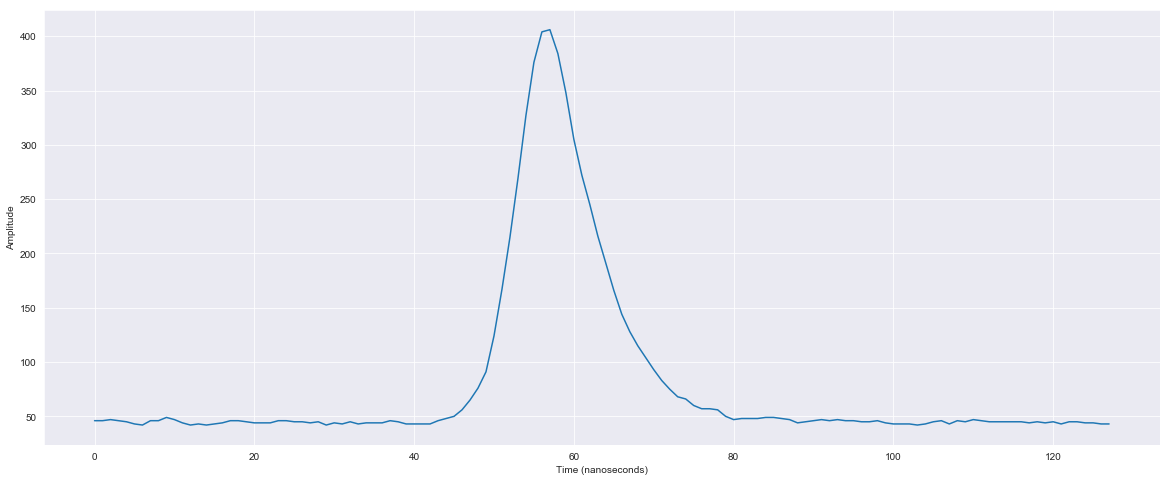

In [6]:
# Plot a transmitted light pulse energy signature. This will be roughly Gaussian
txwave = lvis["TXWAVE"][wavenumber]

plt.figure(figsize=(20,8))
plt.plot(txwave)

# label the axes
plt.xlabel('Time (nanoseconds)')
plt.ylabel('Amplitude')

## Do all transmitted pulses look the same?

...almost

Text(0, 0.5, 'Amplitude')

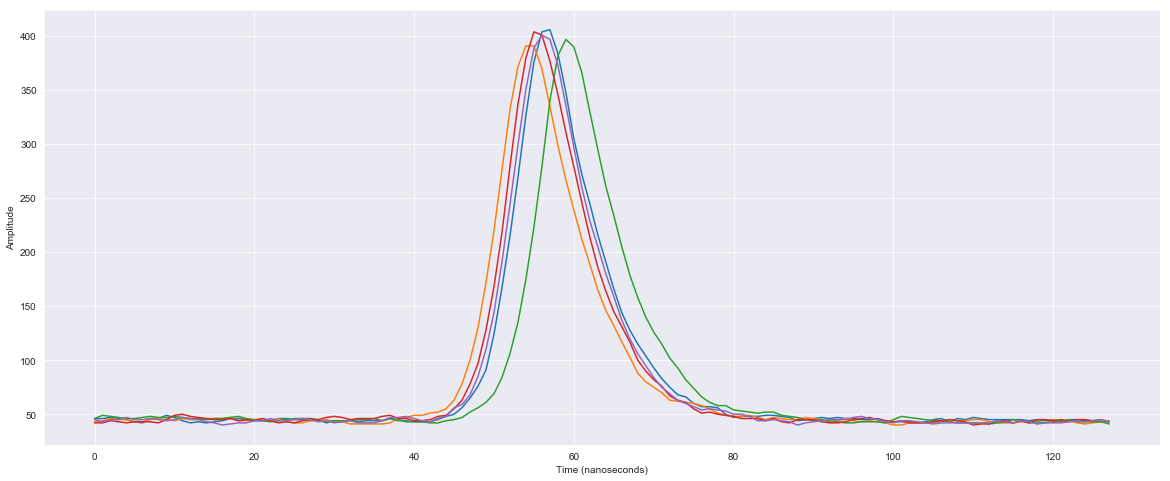

In [7]:
# collect a few transmitted pulses and plot them

txpulses = [lvis['TXWAVE'][i] for i in range(wavenumber, wavenumber+5)]

plt.figure(figsize=(20,8))

plt.plot(np.array(txpulses).T)
# label the axes
plt.xlabel('Time (nanoseconds)')
plt.ylabel('Amplitude')

## Plot a received LiDAR pulse

The received energy is sampled 1024 times. It's more complex, and needs to be characterised in more detail. Again, in plots of `RXWAVE` time travels from left to right - the rightmost peak is the last thing the instrument gathers a return from (often, ground).

Text(0, 0.5, 'Amplitude')

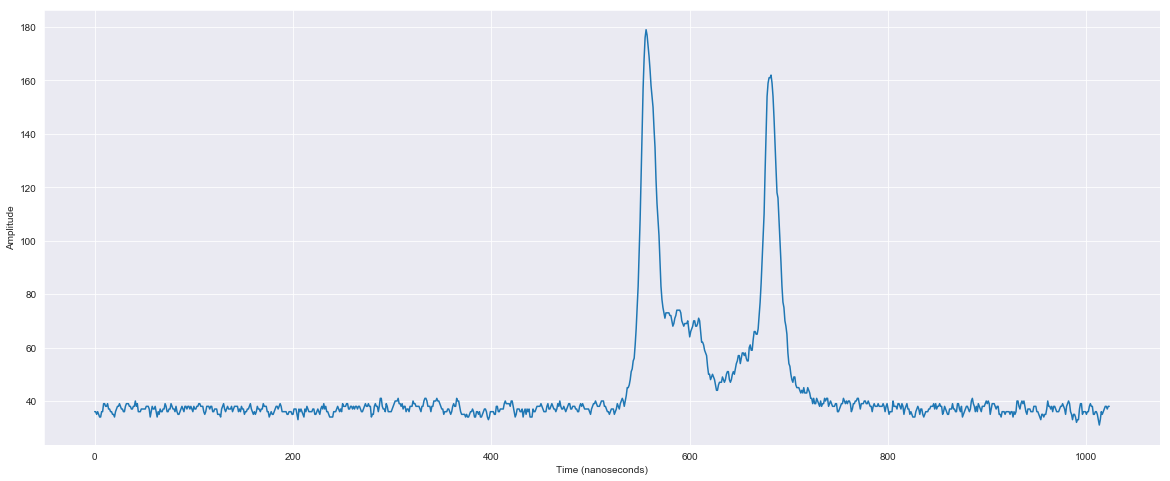

In [8]:
# collect and plot a return pulse sample
rxwave = lvis["RXWAVE"][wavenumber]

plt.figure(figsize=(20,8))
plt.plot(rxwave)

# label the axes
plt.xlabel('Time (nanoseconds)')
plt.ylabel('Amplitude')

## Do all received pulses look the same?

No - let's prove it:

Text(0, 0.5, 'Amplitude')

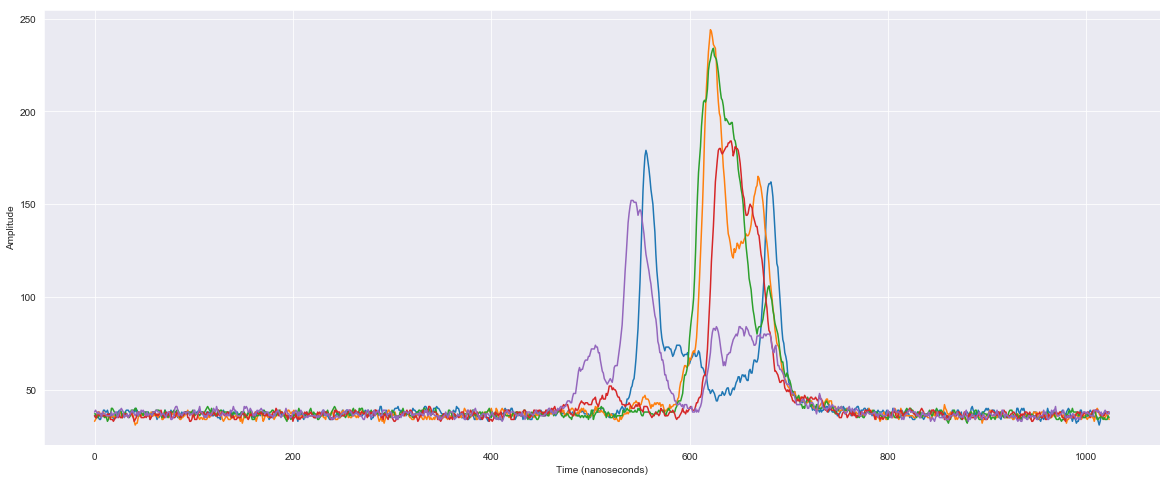

In [9]:
# collect a few transmitted pulses and plot them

rxpulses = [lvis['RXWAVE'][i] for i in range(wavenumber, wavenumber+5)]

plt.figure(figsize=(20,8))

plt.plot(np.array(rxpulses).T)
# label the axes
plt.xlabel('Time (nanoseconds)')
plt.ylabel('Amplitude')

For every outgoing pulse, the return is different - depending on the terrain being flown over. Each 'peak' in the return pulse represents a thing which the light pulse hit, causing a reflection of energy back to the receiver (a return).

For the rest of this workshop, we look a little deeper at turning those peaks into meaningful observations.

### Finding peaks in a waveform

Detecting peaks in the returned light energy (`RXWAVE`) is the first step in creating a 3D map of the world. As shown in the image above, these reflection intensity peaks tell us where the light pulse intercepted a reflector. The next step is to isolate peaks so that we can attach a time to each - and work out it's range to the sensor.

Using our return waveform, play with the parameters `threshold`, `height`, `rel_height` and `distance` to see if the peaks detected look reasonable to you.

Also, look at some different peaks. Define a new `wavenumber` for another index number (up to the length of the dataset). See if you can find some parameters which work reasonably well for each different waveform.


Text(0, 0.5, 'Amplitude')

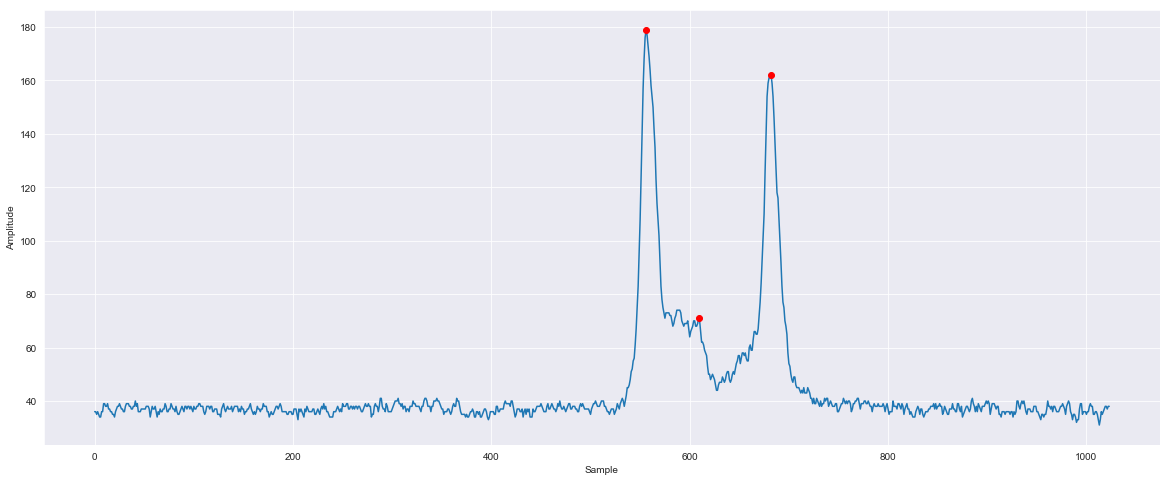

In [10]:
# Detect peaks

peaks, properties = signal.find_peaks(rxwave, threshold=0.01, height=60, rel_height=100, distance=40)

plt.figure(figsize=(20,8))
plt.plot(rxwave)
plt.plot(peaks, properties['peak_heights'],'or' )

# label the axes
plt.xlabel('Sample')
plt.ylabel('Amplitude')

In [11]:
properties

{'peak_heights': array([179.,  71., 162.]),
 'left_thresholds': array([3., 2., 1.]),
 'right_thresholds': array([2., 1., 3.])}

In [12]:
print('Peak locations in the waveform (sample #): {}'.format(peaks))

Peak locations in the waveform (sample #): [556 609 682]


## More about these peaks - energy and elevation

We've seen some peaks in the return waveform, plotted along a time axis. How do we convert those to something meaningful, like elevations?

We'll use two more attributes of the LVIS L1 data:

| name | description |
| --- | --- |
| Z0 | height of the highest RXWAVE sample |
| Z1023 | height of the lowest RXWAVE sample |

Using the peak timings we've seen above, let's convert the return waveform to heights.


In [13]:
# Using the LVIS data spec, the distance in metres between the first and last RXWAVE sample should be Z0 - Z1023

signaldistance = lvis['Z0'][wavenumber] - lvis['Z1023'][wavenumber]


print('height of highest sample: {}m'.format(lvis['Z0'][wavenumber]))
print('height of lowest sample: {}m'.format(lvis['Z1023'][wavenumber]))
print('Distance between first and last sample: {} m'.format(signaldistance))


height of highest sample: 211.49876403808594m
height of lowest sample: 58.7789192199707m
Distance between first and last sample: 152.7198486328125 m


In [14]:
# create an array of elements to plot our waveform against

z_elements=np.linspace(lvis['Z0'][wavenumber], lvis['Z1023'][wavenumber], 1024)

In [15]:
# translate our peaks to distances

peakheights = z_elements[peaks]
print('height of peaks (m): {}'.format(peakheights))

height of peaks (m): [128.49560302257072 120.5834311991493  109.68553415934244]


In [16]:
# convert to relative heights

relpeakheights = peakheights - peakheights[-1]
print('height of peaks (m): {}'.format(relpeakheights))

height of peaks (m): [18.81006886322828  10.897897039806864  0.               ]


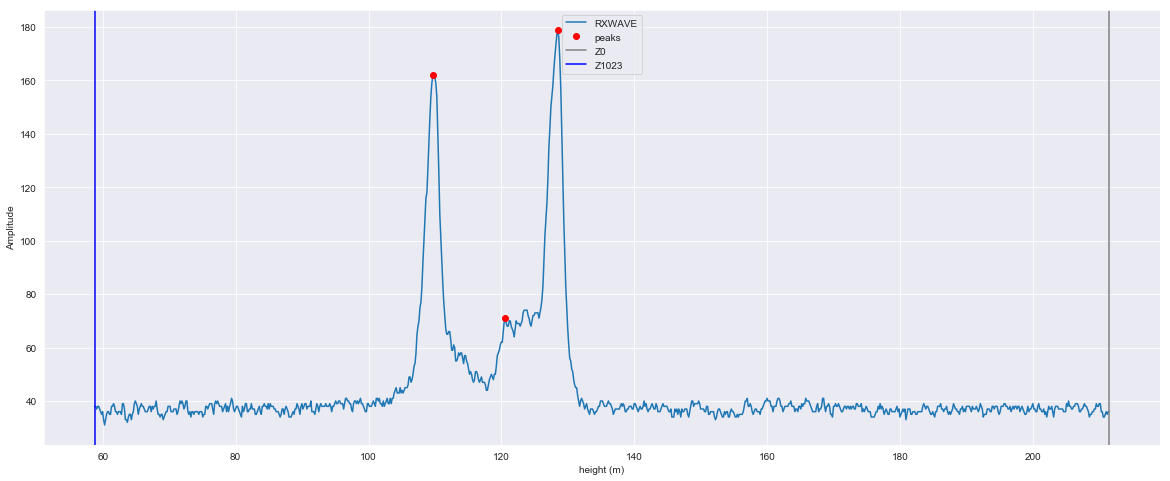

In [17]:
plt.figure(figsize=(20,8))
plt.plot(z_elements, rxwave, label='RXWAVE' )
plt.plot(peakheights, properties['peak_heights'],'or', label='peaks' )

plt.axvline(lvis['Z0'][wavenumber], color='gray', label='Z0')
plt.axvline(lvis['Z1023'][wavenumber], color='blue', label='Z1023')

# label the axes
plt.xlabel('height (m)')
plt.ylabel('Amplitude')
plt.legend(loc='best')

Looking at the waveform, what component of the forest structure reflected the most energy?

## Absolute elevations?

Using L1 data, we need to know more about what `Z0` and `Z1023` mean in order to get absolute elevations - and we also need to know where the aircraft was. We know how far from the aircraft to ground, but don't have a areliable way to determine which part of the L1 data are 'ground' - it is not `Z1023`, and we don't know how NASA have decided what peak represents ground.

## Discussion

What we've done so far is inspect some waveforms, and made some basic attempts at generating 'points' from 'waveforms' by converting returned energy to discrete peaks and sample numbers to distances.

What else could we infer from the data we have here? Discuss:
- what might each return represent?
- would examining the peak shape in more detail help us decide?
- what else can we find out without absolute elevations?


## Inspecting LIDAR data

Once we've found peaks, we need to use additional information to georeference them and create a meaningful dataset. For LVIS Gabon data, this is already partially done, and contained in the tab-delimited text file 'ILVIS2_GA2016_0222_R1611_036312.TXT'.

These are 'level 2' data - with one more processing step than the level 1 data we worked with from the HDF file. They contain georeferenced 'highest mode' and 'lowest mode' points, which usually correspond to 'ground' and 'treetops'.

We'll import those data into a Pandas dataframe and take a look at them.

**Note**

To import the L2 ASCII file, we need to:
- remove the hash symbol from the header row (line 13)
- ask Pandas to skip 12 lines
- tell Pandas that the delimiter is one or more spaces (`\s+`)

The dataset provided for this tutorial is already modified to suit - be aware that the starting hash symbol on the header line in LVIS level 2 files will be interpreted by `pandas.read_csv` as an additional column


In [18]:
# import the sample LVIS L2 file into a dataframe

lvis_l2 = pd.read_csv('../data/ILVIS2_GA2016_0222_R1611_036312.TXT',
                      sep='\s+',
                      skiprows=12)

In [ ]:
lvis_l2.head()

,LFID,SHOTNUMBER,TIME,GLON,GLAT,ZG,TLON,TLAT,ZT,RH10,...,RH97,RH98,RH99,RH100,AZIMUTH,INCIDENTANGLE,RANGE,FLAG1,FLAG2,FLAG3
0,1657440012,567682,36312.815,9.852679,0.564067,109.76,9.852662,0.564073,131.26,-1.34,...,20.38,20.68,21.05,21.50,107.89,5.169,5161.82,1,1,1
1,1657440012,567683,36312.816,9.852682,0.564129,99.59,9.852659,0.564136,128.55,4.85,...,27.02,27.69,28.29,28.96,107.08,5.140,5163.01,1,1,1
2,1657440012,567684,36312.817,9.852670,0.564194,108.22,9.852660,0.564197,121.65,-1.12,...,12.17,12.54,12.91,13.44,106.27,5.111,5163.61,1,1,1
3,1657440012,567685,36312.818,9.852668,0.564257,105.12,9.852643,0.564264,137.59,2.61,...,30.68,31.28,31.88,32.47,105.45,5.083,5160.01,1,1,1
4,1657440012,567686,36312.819,9.852659,0.564322,104.93,9.852632,0.564329,145.76,6.12,...,39.12,39.57,40.17,40.84,104.62,5.057,5155.21,1,1,1


Again, we focus only on a few of key parameters:

| name | description |
| --- | --- |
| ZG | the georeferenced elevation (metres) of the lowest return peak median |
| GLAT | the latitude (in decimal degrees) of the lowest return peak median |
| GLON | the longitude (in decimal degrees) of the lowest return peak median |
| ZT | the georeferenced elevation (metres) of the highest return peak median |
| TLAT | the latitude (in decimal degrees) of the highest return peak median |
| TLON | the longitude (in decimal degrees) of the highest return peak median |

We'll inspect the data shortly - using standard Python plotting tools. Before we do, we'll take a look at how our peak finding results match with NASA's..

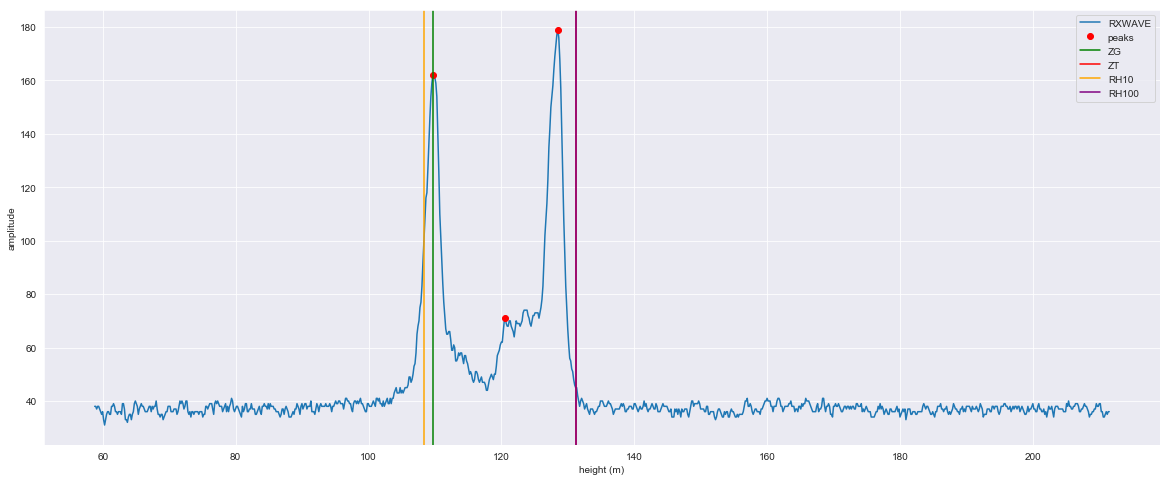

In [ ]:
# adapted from https://lvis.gsfc.nasa.gov/workshop/py_waveplot.py
# Detect peaks

# uncomment the next line and choose different numbers to try different wave forms
#rxwave = lvis["RXWAVE"][4]

plt.figure(figsize=(20,8))
plt.plot(z_elements,rxwave,  label='RXWAVE')
plt.plot(peakheights, properties['peak_heights'],'or', label='peaks' )

plt.axvline(lvis_l2['ZG'][wavenumber], color='green', label='ZG')
plt.axvline(lvis_l2['ZT'][wavenumber], color='red',  label='ZT')
plt.axvline(lvis_l2['RH10'][wavenumber]+lvis_l2['ZG'][wavenumber], color='orange',  label='RH10')
plt.axvline(lvis_l2['RH100'][wavenumber]+lvis_l2['ZG'][wavenumber], color='purple',  label='RH100')

# label the axes
plt.xlabel('height (m)')
plt.ylabel('amplitude')
plt.legend(loc='best')

We can see that our peaks don't line up with `ZG` and `ZT` - NASA use the percentage of energy returned to the sensor to help determine where things are, and we can see that peak boundaries are likely also used.

How could we asses this? (do we have other data in our peak `properties` dataset which might help?)

Is it realistic to use the ramp-up and fall-off points of signals as observations - or should their peaks be the key indicator? discuss...

### Plotting both ZG and ZT

We'll plot both datasets using contrasting colour scales, to see if we can visualise the structure of the forest that was surveyed.

In this view ZG and ZT seem reasonably separated - like 'ground' and 'tree tops'.


Text(0.5, 0, 'Elevation (metres)')

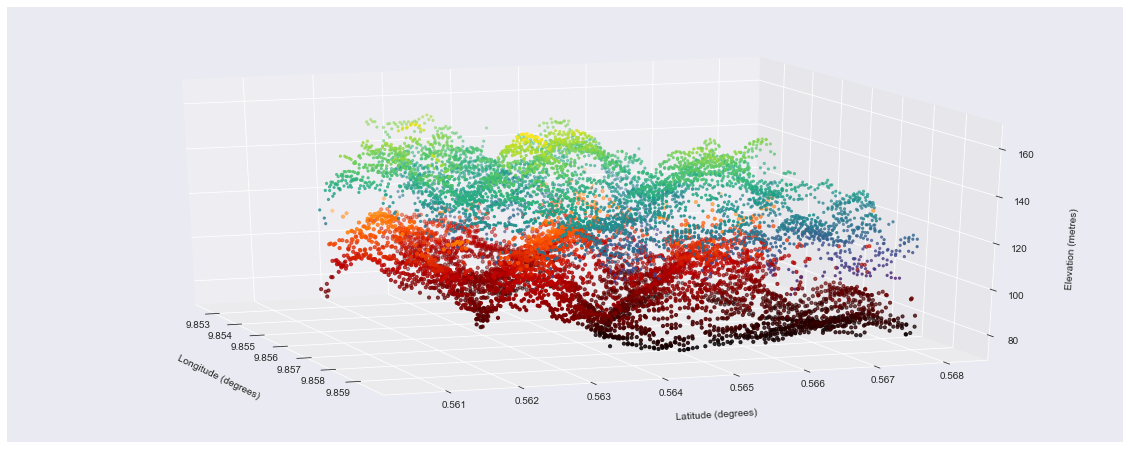

In [ ]:
# plot ground elevations (lowest returns) and treetops (highest returns)
# using contrasting colour maps, it seems we've got both.

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lvis_l2['GLON'][0:5000],
           lvis_l2['GLAT'][0:5000],
           lvis_l2['ZG'][0:5000],
           c=lvis_l2['ZG'][0:5000],
           cmap='gist_heat', s=10)

ax.scatter(lvis_l2['TLON'][0:5000],
           lvis_l2['TLAT'][0:5000],
           lvis_l2['ZT'][0:5000], 
           c=lvis_l2['ZT'][0:5000], 
           cmap='viridis', s=5)
ax.view_init(20, -20)

# label the axes
ax.set_xlabel('Longitude (degrees)', labelpad=25)
ax.set_ylabel('Latitude (degrees)', labelpad=25)
ax.set_zlabel('Elevation (metres)', labelpad=15)

### ZG only - is it always 'ground'?

Now looking at just ZG. These seem noisy on their own - it's possible that a number of ZG points are still canopy returns, and not actual ground.

What decision heuristic might lead to this decision about point labelling?


Text(0.5, 0, 'Elevation (metres)')

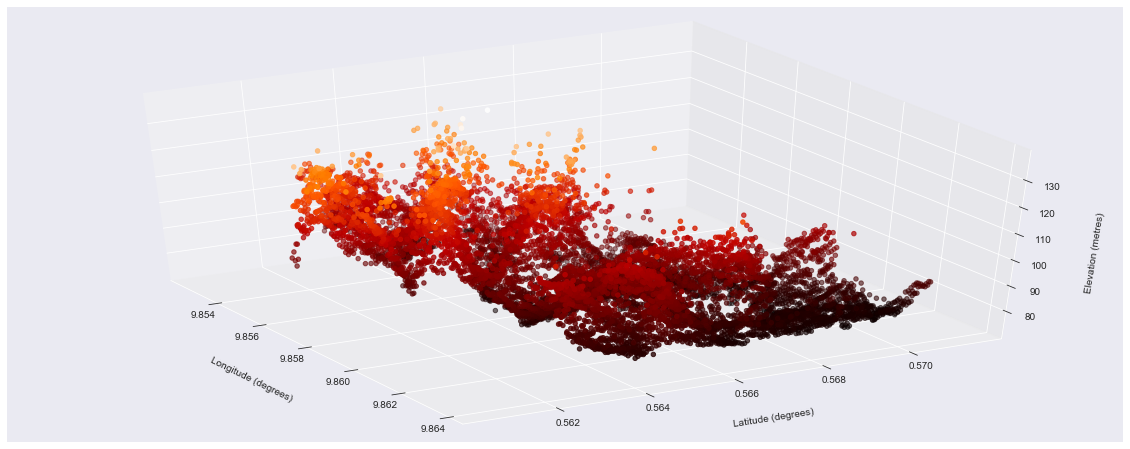

In [ ]:
# Looking deeper - let's plot ground elevations (lowest returns)

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lvis_l2['GLON'][0:10000], lvis_l2['GLAT'][0:10000],
           lvis_l2['ZG'][0:10000], c=lvis_l2['ZG'][0:10000], cmap='gist_heat')
ax.view_init(40, -30)

# label the axes
ax.set_xlabel('Longitude (degrees)', labelpad=25)
ax.set_ylabel('Latitude (degrees)', labelpad=25)
ax.set_zlabel('Elevation (metres)', labelpad=15)

### ZT only - the treetops

Now looking at just ZT. While it's harder to spot ZT returns which might not be actual trees, these data seem reasonably representative of canopy tops.

Text(0.5, 0, 'Elevation (metres)')

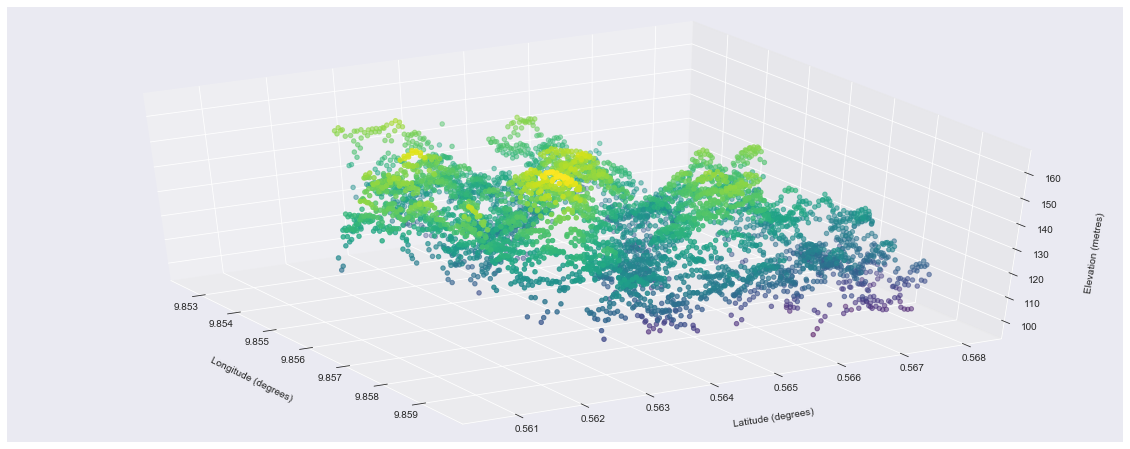

In [ ]:
# canopy tops (highest elevations)

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lvis_l2['TLON'][0:5000], lvis_l2['TLAT'][0:5000],
           lvis_l2['ZT'][0:5000], c=lvis_l2['ZT'][0:5000], cmap='viridis')
ax.view_init(40, -30)

# label the axes
ax.set_xlabel('Longitude (degrees)', labelpad=25)
ax.set_ylabel('Latitude (degrees)', labelpad=25)
ax.set_zlabel('Elevation (metres)', labelpad=15)

## Eyeballing tree height

We can get an idea of tree heights in our data by plotting the difference between ground and trees. We see here that most of out 'trees' range from 10 to 40 m in height above ground.

Text(0.5, 0, 'Difference (metres)')

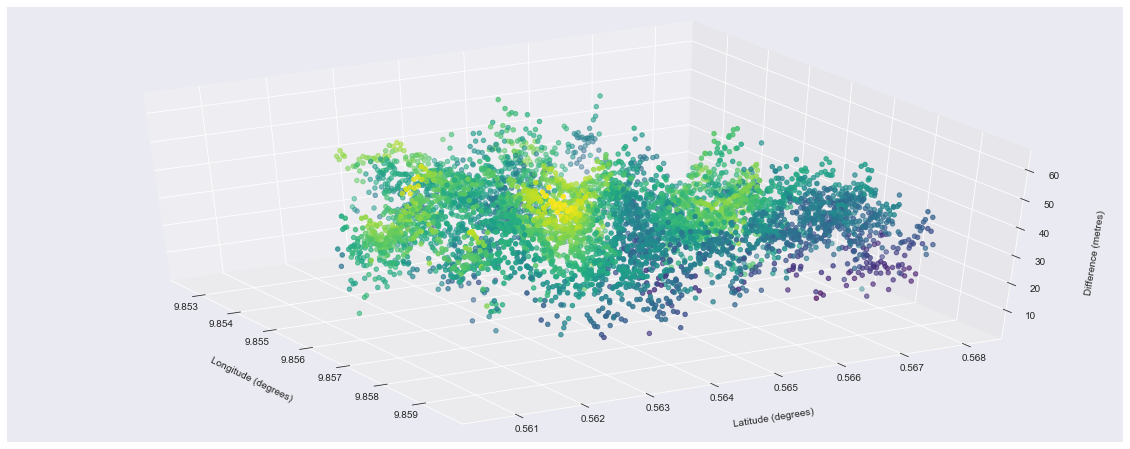

In [ ]:
# difference between ZG and ZT

Zdiff = lvis_l2['ZT'][0:5000]-lvis_l2['ZG'][0:5000] 

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lvis_l2['TLON'][0:5000],
           lvis_l2['TLAT'][0:5000],
           Zdiff,
           c=lvis_l2['ZT'][0:5000],
           cmap='viridis')

ax.view_init(40, -30)

# label the axes
ax.set_xlabel('Longitude (degrees)', labelpad=25)
ax.set_ylabel('Latitude (degrees)', labelpad=25)
ax.set_zlabel('Difference (metres)', labelpad=15)

Using a histogram to check on ourselves, we see that our eyeballing was OK. However - we always need to check!

(array([  13.,   30.,  125.,  400.,  760., 1344., 1479.,  670.,  158.,
          21.]),
 array([ 3.510000000000005,  9.408000000000005, 15.306000000000006,
        21.204000000000008, 27.102000000000007, 33.00000000000001 ,
        38.89800000000001 , 44.79600000000001 , 50.69400000000001 ,
        56.59200000000001 , 62.49000000000001 ]),
 <a list of 10 Patch objects>)

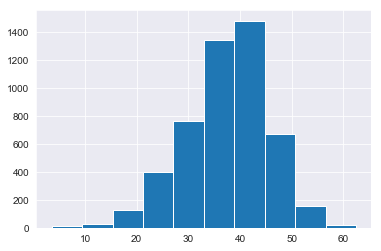

In [ ]:
plt.hist(Zdiff)

## LiDAR waveform wrapup

#### LVIS Level 1 data

In this tutorial we have loaded data fron HDF files into a dictionary-like object in Python. We've learned how to access that object and extract data from it. We've also learned about what attributes come in NASA LVIS data packages.

Next, we've made plots of transmitted and received LiDAR 'waveforms' - and learned that these are really curves which describe the light energy transmitted and received by a LiDAR sensor over time.

We've seen one method of finding peaks in Python, and tried to figure out what each of these peaks means.

#### LVIS L2 data

We read a text file into a Pandas dataframe, and learned about a small idiosyncracy of text formatting and how Pandas sees parts of files.

We generated 3D plots in Python to visualise a small subset of our data, and were able to interpret the data based on what it looks like. This, in turn, proves useful in decision-making about how to use data. For example, can we always assume that the final return in a LiDAR dataset is 'ground'?


### How might you apply all this - data decision making?

We've got the basic toolkit now to unpack all of NASA's LVIS collection, inspect the data, test it's veracity, and make decisions about what to do with it.

For example:
- if you were estimating forest structure, would you always now assume that `Z1023` is ground?
- what could you do to test your assumption? (*hint: how many peaks does the return have?*)




## Final word - playing with the LVIS team function

Much of the work above was inspired by this function, provided by the LVIS team (https://lvis.gsfc.nasa.gov/workshop/py_waveplot.py). It's slightly modified to work with the data we have already downloaded, and inside a notebook cell. Have a play!

In [ ]:
#PLOT A WAVEFORM WITH RH VALUES

#print "Usage: python py_waveplot.py <path_to_L1B_HDF5_file> <path_to_L2_txt_file> "

# Updated on 9 March 2018
# Added ability to autodetect waveform size
%matplotlib inline
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt

mypath = '../data/ILVIS1B_GA2016_0222_R1611_036312.h5'
mytxtpath = '../data/ILVIS2_GA2016_0222_R1611_036312.TXT'

lvis = h5py.File(mypath,'r')
#get wave index from shotnumber and test if exists
all_shotnums = np.array(lvis['SHOTNUMBER'])
wave_idx = ''
Zmax = ''
wfrange = ''
wfsize = ''

def checkIdxVal():
    global wave_idx
    global Zmax
    global wfrange
    global wfsize
    # Detecting waveform size
    for member in lvis:
        if member.startswith('Z'):
            wfsize = member.strip('Z')
    Zmax = ''.join(['Z',wfsize])
    wfrange = int(wfsize) + 1
    print('wfrange: {}'.format(wfrange))
    
    try:
        wave_idx = np.where(all_shotnums==myshotnum)[0][0]
        plotWaveform()
    except IndexError:
        print('Shot number entered does not exist in this dataset.')

def plotWaveform():
    global wave_idx
    global Zmax
    global wfrange
    global wfsize
    
    print('zmax: {}'.format(Zmax))
    print('wfrange: {}'.format(wfrange))
    #extract the single waveform and elevation attributes Z0 and Z1023;
    waveform = lvis['RXWAVE'][wave_idx]
    Z0 = lvis['Z0'][wave_idx]
    Z1023 = lvis[Zmax][wave_idx]

    #find the elevation difference from Z0 to Z1023 and divide into 1023 equal intervals
    zstretch = np.add(Z1023,np.multiply(range(wfrange,0,-1),((Z0-Z1023)/int(wfsize))))

    #search the L2 text file and extract the RH25, RH50.....RH100 values for the waveform you are querying
    with open(mytxtpath) as f:
        for line in f:
            try:
                myshot = line.split()[1]
                if int(myshot)==int(myshotnum):
                    ZG = float(line.split()[5])
                    ZT = float(line.split()[8])
                    RH25 = float(line.split()[12])+ZG
                    RH50 = float(line.split()[17])+ZG
                    RH75 = float(line.split()[22])+ZG
                    RH10 = float(line.split()[9])+ZG 
                    break
            except ValueError:
                pass
                
    #set the z range limits for plotting the waveform to crop the noise  
    zmin=RH10-(ZT-RH10)/6   #sets zmin at 15% below the waveform range defined in RH10-ZT
    zmax=ZT+(ZT-RH10)/18   #sets zmax at 5% above the waveform range defined in RH10-ZT
    
    print('zmin: {}'.format(zmin))
    print('zmax: {}'.format(zmax))
    print('zstretch: {}'.format(zstretch))
    
    #crop the waveform and elevation arrays to the z range limits
    x=zstretch>=zmin #this returns boolean True/False based on the comparison condition statement
    y=zstretch<=zmax 
    z=(x==y) #this creates a combined boolean result from the previous two condition statements
    waveform_crop = []
    zstretch_crop = []
    for i in range(0,len(waveform)):
        if z[i]==True:
            waveform_crop.append(waveform[i])
            zstretch_crop.append(zstretch[i])  
    
    print('waveform crop: {}'.format(waveform_crop))
    print('zstretch crop: {}'.format(zstretch_crop))


    #plot the waveform as matplotlib figure
    fig = plt.figure(figsize=(15, 6))
    figplot = fig.add_subplot(121) 
    figplot.plot(waveform,zstretch)
    plt.ylabel('elevation(m)')
    plt.xlabel('amplitude')

    figplot = fig.add_subplot(122) 
    figplot.plot(waveform_crop,zstretch_crop)
    figplot.hlines(ZT,min(waveform),max(waveform),lw=1,linestyle='-', color='b',label='ZT')
    figplot.hlines(RH75,min(waveform),max(waveform),lw=1,linestyle='-', color='g',label='RH75')
    figplot.hlines(RH50,min(waveform),max(waveform),lw=1,linestyle='-', color='y',label='RH50')
    figplot.hlines(RH25,min(waveform),max(waveform),lw=1,linestyle='-', color='orange',label='RH25')
    figplot.hlines(ZG,min(waveform),max(waveform),lw=1,linestyle='-', color='r',label='ZG')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=5, mode="expand", borderaxespad=0.)
    plt.ylabel('elevation(m)')
    plt.xlabel('amplitude')
    plt.show(block=False)

while 1:
    available = ''.join(['\nShot numbers available in this dataset: ',str(all_shotnums.min()),' - ',str(all_shotnums.max())])
    print(available)
    
    try:
        myshotnum = int(input("Please enter shot number: "))
        checkIdxVal()
    except:
        print('Must be an integer.')
    


Shot numbers available in this dataset: 567682 - 1437610
